In [2]:
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.distances import distance_array

import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import random
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

import torch
from torch import nn, optim

/home/eurastof/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Making coordinate data (b2ar)


dirs = glob.glob("../binding_spots_project/gpcr_sampling/b2ar/b2ar_centered_aligned/*")
data = []
ids = []
for d in dirs:
    print(d)
    system = d.split("/")[-1]
    cosmos = mda.Universe(d + "/step6.6_equilibration.gro", glob.glob(f"{d}/*xtc"))
    heavy = cosmos.select_atoms("protein and not type H")
    coords = []
    for ts in cosmos.trajectory[0:-1:2]:
        pos = heavy.positions.flatten()
        coords.append(pos.reshape(1, pos.shape[0]))
    coords = np.concatenate(coords, axis=0)
    ids += [system for _ in range(coords.shape[0])]
    data.append(coords)

data = np.concatenate(data)


cols = []
for resid, i in enumerate(range(0, data.shape[1], 3)):
    cols += [f"{resid}x", f"{resid}y", f"{resid}z"]

D = pd.DataFrame(data, columns=cols)
D["system"] = ids


D.to_csv("./data/b2ar-heavy-atoms.csv")

# Orthogonality loss

In [ ]:
class OrthoLoss(nn.Module):
    
    def __init__(self, type="mse", reduction="mean"):
        """
        A loss function for making a latent space orthonormal. In this case orthonormality
        means that given an input matrix X of shape(n, d) of n data points
        of d-dimensions, (X.T @ X) / n will be a d-dimensional identity matrix. The divisor
        of n makes sure that if batch size is changed, the orthonormality condition stays the same.
        
        The loss defined by "type" is calculated over the (d,d) shaped error matrix (X.T @ X) / n - eye(d).
        
        The batch size should be sufficiently large and decorrelated for this loss to work.
        
        Parameter
        ---------
        type: one of ("mse", "l1", "l2"), default="mse"
            How the loss is calculated from the error matrix.
            mse: mean squared error (squared l2 error)
            l1:  mean absolute error
            l2:  root mean squared error
        reduction: one of ("sum", "mean"), default="mean"
            How different batch size affects the result. With "mean" the error magnitude should stay
            the same independent of the batch size. With "sum" the error matrix above is multiplied
            by batch size, so the error grows linearily with batch size.
            NOTE! due to  the error being calculated for the whole batch at once, the sum-reduction
            has a different meaning to most other loss functions. With the mse type the output scales
            as squared to the batch size instead of linearily, since the reduction is applied before
            squaring.
        """
        super().__init__()
        
        types = {"mse": self._mse,
                 "l1":  self._l1,
                 "l2":  self._l2}
        errors = {"sum":  self._sum_error,
                  "mean": self._mean_error}

        if type not in types:
            raise ValueError(f"Unrecognised loss type \"{type}\"")
        if reduction not in errors:
            raise ValueError(f"Unrecognised loss reduction \"{reduction}\"")
        self.type=type
        self.reduction=reduction
        self._calc_loss = types[type]
        self._calc_err  = errors[reduction]
    
    def forward(self, X):
        n = X.shape[0]
        d = X.shape[1]
        nc_var = X.T @ X
        target = torch.eye(d, device=X.device)
        error = self._calc_err(nc_var, target, n)
        return self._calc_loss(error, d)
    
    def _mse(self, error, d):
        return (error*error).mean()
    
    def _l2(self, error, d):
        return self._mse(error,d).sqrt()
    
    def _l1(self, error, d):
        return torch.abs(error).mean()
    
    def _mean_error(self, dp, tgt, n):
        return dp/n - tgt
        
    def _sum_error(self, dp, tgt, n):
        return dp - tgt*n


## Autoencoder

In [2]:

class Autoencoder(BaseEstimator, TransformerMixin, nn.Module):

    def __init__(self, in_shape=10, enc_shape=2, middle_shape=5, n_hidden=1, loss_fn=nn.L1Loss(), lr=1e-3):
        
        super().__init__()
        self.loss_fn = loss_fn
        self.lr = lr 
        self.n_hidden = n_hidden # number of hidden layers
        self.in_shape = in_shape # input dimension
        self.enc_shape = enc_shape # dimension of encoding
        self.middle_shape = middle_shape # hidden layer dimensions
        
        encoder_layers = [nn.Linear(self.in_shape, self.middle_shape), nn.ReLU(), nn.Dropout(0.2)] # initialize encoder layer list
        decoder_layers = [nn.Linear(self.enc_shape, self.middle_shape), nn.ReLU(), nn.Dropout(0.2)] # initialize decoder layer list

        for i in range(n_hidden - 1): # Add layers to encoder and decoder according to n_hidden and middle shape
            encoder_layers.append(nn.Linear(self.middle_shape, self.middle_shape))
            encoder_layers.append(nn.ReLU())
            encoder_layers.append(nn.Dropout(0.2))
            decoder_layers.append(nn.Linear(self.middle_shape, self.middle_shape))
            decoder_layers.append(nn.ReLU())
            decoder_layers.append(nn.Dropout(0.2))
            
        encoder_layers.append(nn.Linear(self.middle_shape, self.enc_shape)) # Final encoder layer
        decoder_layers.append(nn.Linear(self.middle_shape, self.in_shape)) # Final decoder layer
        #decoder_layers.append(nn.Sigmoid()) # Sigmoid at end of deocder?

        self.encode = nn.Sequential(*encoder_layers) # Make encoder
        self.decode = nn.Sequential(*decoder_layers) # Make decoder
        

    def fit(self, X, y=None, n_epochs=20, batch_size=32, verbose=False):
        self.training = True # Enables e.g. dropouts to work
        X = torch.Tensor(X)
        indices = [i for i in range(X.shape[0])]
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr) # Adam only atm
        
        for epoch in range(n_epochs):
        
            random.shuffle(indices) # random shuffle to get random batches for each epoch
            batches = [i for i in range(0, len(indices), batch_size)]

            for i in range(len(batches) - 1):

                batch_X = X[indices[batches[i]:batches[i+1]]]
                self.optimizer.zero_grad() # reset optimizer
                
                encoded = self.encode(batch_X)
                decoded = self.decode(encoded)

                loss = self.loss_fn(decoded, batch_X)
                loss.backward() # Backpropagate
                self.optimizer.step() # Apply changes
            
            if verbose:
                print(f'epoch {epoch} \t Loss: {loss.item():.4g}')
        
        return self

    def transform(self, X, y=None):
        encoded = self.encode(torch.Tensor(X))
        return encoded.cpu().detach().numpy()
    

    def inverse_transform(self, X, y=None):
        decoded = self.decode(torch.Tensor(X))
        return decoded.cpu().detach().numpy()
    
    def score(self, X, y=None):
        encoded = self.transform(X)
        decoded = self.inverse_transform(encoded)
        
        return -self.loss_fn(torch.Tensor(X), torch.Tensor(decoded)) # Take negative to make GridSearchCV work properly
        
    


## Autoencoder testing

In [3]:
#device = ('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"  # GridSearchCV having issues with GPUs
print(f"Using {device} device.")

Using cpu device.


with open('./data/b2ar_CA_coords.pickle', 'rb') as handle:
    data_dict = pkl.load(handle)

X = np.concatenate([v for k, v in data_dict.items()]) # Input data (CA coordinates)
ids = np.concatenate([[i for i in range(v.shape[0])] for v in data_dict.values()]).reshape(-1,1) # Id for every lipid environment



In [ ]:
X = np.load("data/b2ar_d3_common")

In [20]:

test = 0.25
index = [_ for _ in range(X.shape[0])]
random.shuffle(index)
test_index = index[:int(test*len(index))]
train_index = index[int(test*len(index)):]
test_X = X[test_index,:]
train_X = X[train_index,:]

scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)

test_X_scaled = torch.Tensor(scaler.transform(test_X))
test_ids = ids[test_index]
train_X_scaled = torch.Tensor(scaler.transform(train_X))
train_ids = ids[train_index]
names = ["a2ar", "d3", "b2ar"]


In [6]:
encoding_dim = 2
middle_dim = 512
n_hidden = 1

autoencoder = Autoencoder(in_shape=X.shape[1], enc_shape=encoding_dim, middle_shape=middle_dim, n_hidden=n_hidden)
autoencoder.fit(train_X_scaled, n_epochs=3, verbose=True)


epoch 0 	 Loss: 0.6543
epoch 1 	 Loss: 0.5793
epoch 2 	 Loss: 0.6249


Autoencoder(in_shape=933, middle_shape=512)

In [7]:
# Test set

encoded = autoencoder.transform(test_X_scaled)
decoded = autoencoder.inverse_transform(torch.Tensor(encoded))
decoded_orig_space = scaler.inverse_transform(decoded)

# L1 loss (Å)

error = np.mean(np.abs(decoded_orig_space - test_X))
print(f"Reconstruction error: {error} Å ")



Reconstruction error: 1.5028060674667358 Å 


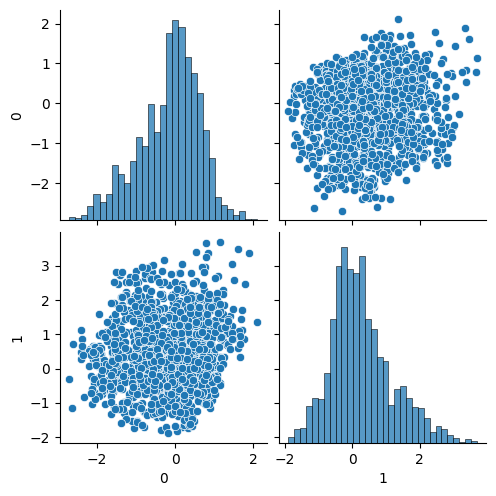

In [8]:
# Encoding scatter

sns.pairplot(pd.DataFrame(encoded))


## Pipeline

In [33]:
# Grid of parameters for gridsearch

param_grid = {
    "Autoencoder":{
        "Autoencoder__middle_shape": [512],
        "Autoencoder__enc_shape": [2],
        "Autoencoder__n_hidden": [1]
    },
    "GMM": {
        "n_components": [4]
    }
}


In [34]:
# Function to search parameters and return best model

def best_pipeline(transformer, param_grid, X, cv=2):
    
    step_names = ["Scaler", "Autoencoder"]
    params = {key: val for k, d in param_grid.items() for key, val in d.items() if k in step_names}
    pipe = Pipeline(
        steps=[
            (step_names[0], StandardScaler()),
            (step_names[1], transformer),
        ]   
    )
    
    gridsearch = GridSearchCV(pipe, param_grid=params, verbose=3, cv=cv)
    gridsearch.fit(X)
    
    return gridsearch.best_estimator_
    

## Pipeline testing

In [39]:
best = best_pipeline(Autoencoder(in_shape=X.shape[1]), param_grid, X)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END Autoencoder__enc_shape=2, Autoencoder__middle_shape=512, Autoencoder__n_hidden=1;, score=-0.721 total time=   2.4s
[CV 2/2] END Autoencoder__enc_shape=2, Autoencoder__middle_shape=512, Autoencoder__n_hidden=1;, score=-0.739 total time=   2.4s


In [41]:
# Test set

encoded = best.transform(test_X)
decoded = best.inverse_transform(torch.Tensor(encoded))

# L1 loss (Å)

error = np.mean(np.abs(decoded- test_X))
print(f"Reconstruction error: {error} Å ")

Reconstruction error: 1.4457952976226807 Å 


## Input perturbation analysis

In [33]:
from sklearn.utils import shuffle

In [34]:

def IPA(X, model):
        
    
    index = np.arange(0, X.shape[1], 3)
    effects = []
    
    for i in index:
        shuffled = X.copy()
        shuffled = shuffle(shuffled)
        rands = np.random.uniform(low=-5, high=5, size=(shuffled.shape[0],1))
        rands = np.concatenate([rands, rands, rands], axis=1)
        shuffled[:, i:i+3] = rands
        encoded = model.transform(shuffled)
        decoded = model.inverse_transform(encoded)
        decoded = s.inverse_transform(decoded)
        L1 = np.mean(np.abs(X - decoded))
        effects += [L1, L1, L1]
    
    return effects
    
       
eff = IPA(X, best)



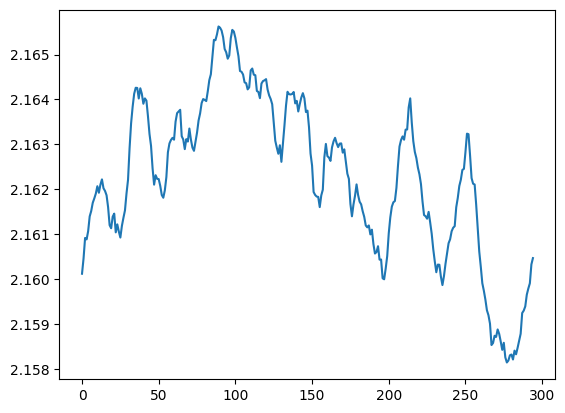

In [35]:
N = 50
E = np.convolve(eff, np.ones(N)/N, mode='valid')

plt.plot(E[0:-1:3])

## Movie creation

cosmos = mda.Universe("/wrk/eurastof/binding_spots_project/gpcr_sampling/b2ar/b2ar_centered_aligned/popc/step6.6_equilibration.gro",
                      "/wrk/eurastof/binding_spots_project/gpcr_sampling/b2ar/b2ar_centered_aligned/popc/centered_aligned10.xtc")
with open("/wrk/eurastof/binding_spots_project/HFSP---Lipid-binding-states/calculations/b2ar_common.ndx") as f:
        lines = "".join(f.readlines())
index = " ".join(re.findall(r"\d+", lines)[1:])
common_ca = cosmos.select_atoms(f"bynum {index}")
common_ca.write("common_ca.gro")

enc_vals = enc[:,1]
n_bins = 10

bins = np.linspace(np.min(enc_vals), np.max(enc_vals), n_bins)

write_file = "enc_dim_2.xtc"


with mda.Writer(write_file, common_ca.n_atoms) as W:
    for i in range(bins.shape[0] - 1):
        
        in_bin = np.where((enc_vals > bins[i]) & (enc_vals < bins[i + 1]))[0]
        
        frames_in_bin = np.array(X[in_bin,:])
        avg_frame_in_bin = np.mean(frames_in_bin, axis=0).reshape(1, frames_in_bin.shape[1])
        distances_to_avg = np.mean(np.sqrt((frames_in_bin - avg_frame_in_bin)**2), axis=1)
        closest = np.argmin(distances_to_avg)
        closest_coords = frames_in_bin[closest,:].reshape(int(frames_in_bin.shape[1]/3), 3)
        common_ca.positions = closest_coords
        W.write(common_ca)
    
    
    



## Visual Check

In [10]:
AE = Autoencoder(in_shape=X.shape[1], middle_shape=1024, n_hidden=1)
scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(train_X)
X_test_scaled = scaler.transform(test_X)
AE.fit(X_train_scaled, verbose=True, n_epochs=3)

epoch 0 	 Loss: 0.6341
epoch 1 	 Loss: 0.6056
epoch 2 	 Loss: 0.6081


Autoencoder(in_shape=933, middle_shape=1024)

In [11]:

encoded = AE.transform(X_test_scaled)
decoded = AE.inverse_transform(torch.Tensor(encoded))
decoded_orig_space = scaler.inverse_transform(decoded)

# L1 loss (Å)

error = np.mean(np.abs(decoded_orig_space - test_X))
print(f"Reconstruction error: {error} Å ")


Reconstruction error: 1.51768958568573 Å 


In [12]:

l1 = np.abs(decoded_orig_space - test_X)
mean_l1 = np.mean(l1, axis=1)
worst = np.argmax(mean_l1)
print(f"Maximum error: {np.amax(mean_l1)}")
print(worst)


Maximum error: 2.695185422897339
1557


In [13]:
worst_reconstruction = decoded_orig_space[worst,:].reshape(311, 3)

cosmos = mda.Universe("../binding_spots_project/gpcr_sampling/b2ar/b2ar_centered_aligned/5%-sdpc/step6.6_equilibration.gro")

cas = cosmos.select_atoms("name CA")
cas.positions = test_X[worst,:].reshape(311, 3)
cas.write("./data/true-for-best.gro")

cas.positions = worst_reconstruction
cas.write("./data/pred-for-best.gro")



In [14]:
w = worst_reconstruction - test_X[worst,:].reshape(311, 3)
distances = np.sum(w**2, axis=1)

rmsd = np.sqrt(np.mean(distances))
print(rmsd)




2.2847679


## a2ar, b2ar, d3 testing

In [27]:
b2ar = mda.Universe("../binding_spots_project/gpcr_sampling/b2ar/5%_sdpc/step6.6_equilibration.gro")
a2ar = mda.Universe("../binding_spots_project/validation/a2ar_site_1/step6.6_equilibration.gro")
d3 = mda.Universe("../binding_spots_project/validation/d3_site_1/step6.6_equilibration.gro")

with open("/wrk/eurastof/binding_spots_project/HFSP---Lipid-binding-states/calculations/b2ar_common.ndx") as f:
        lines = "".join(f.readlines())
b2ar_index = " ".join(re.findall(r"\d+", lines)[1:])
b2ar_common_ca = b2ar.select_atoms(f"bynum {b2ar_index}")

with open("/wrk/eurastof/binding_spots_project/HFSP---Lipid-binding-states/calculations/a2ar_common.ndx") as f:
        lines = "".join(f.readlines())
a2ar_index = " ".join(re.findall(r"\d+", lines)[1:])
a2ar_common_ca = a2ar.select_atoms(f"bynum {a2ar_index}")


with open("/wrk/eurastof/binding_spots_project/HFSP---Lipid-binding-states/calculations/d3_common.ndx") as f:
        lines = "".join(f.readlines())
d3_index = " ".join(re.findall(r"\d+", lines)[1:])
d3_common_ca = d3.select_atoms(f"bynum {d3_index}")

r1_index = list(b2ar_common_ca.resids).index(100)
r2_index = list(b2ar_common_ca.resids).index(241)



In [28]:
X = np.load("data/a2ar_b2ar_d3_common_ca_coordinates.npy")
ids = np.load("data/a2ar_b2ar_d3_ids.npy")


test = 0.25
index = [_ for _ in range(X.shape[0])]
random.shuffle(index)
test_index = index[:int(test*len(index))]
train_index = index[int(test*len(index)):]
test_X = X[test_index,:]
train_X = X[train_index,:]

scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)

test_X_scaled = torch.Tensor(scaler.transform(test_X))
test_ids = ids[test_index]
train_X_scaled = torch.Tensor(scaler.transform(train_X))
train_ids = ids[train_index]

In [29]:
AE = Autoencoder(in_shape=X.shape[1], enc_shape=2, middle_shape=1024, n_hidden=1)
AE.fit(train_X_scaled, n_epochs=3, verbose=True)

epoch 0 	 Loss: 0.6031
epoch 1 	 Loss: 0.5858
epoch 2 	 Loss: 0.5399


Autoencoder(in_shape=786, middle_shape=1024)

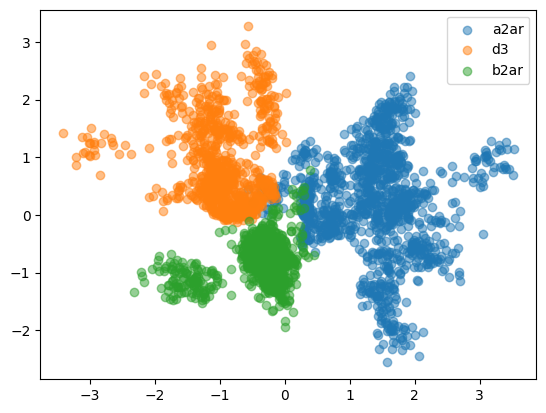

In [30]:

encoded = AE.transform(test_X_scaled)

for i in set(test_ids):
    index = np.where(test_ids == i)[0]
    subset = encoded[index,:]
    plt.scatter(subset[:,0], subset[:,1], alpha=0.5, label=names[i])
plt.legend()
plt.show()



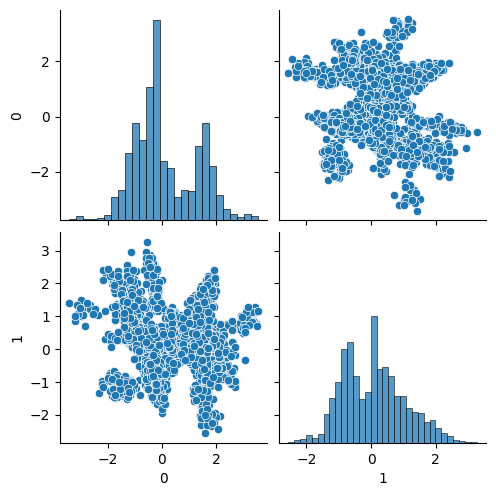

In [31]:
sns.pairplot(pd.DataFrame(encoded))

In [32]:
# First component

projection = encoded[:,1]
z = [(np.abs(v), i) for v, i in enumerate(projection)]
bins = np.linspace(np.amin(encoded[:,0]), np.amax(encoded[:,1]), 10)
distances = []

for i in range(bins.shape[0] - 1):
    in_bin = encoded[(encoded[:,0] > bins[i]) & (encoded[:,0] < bins[i+1])]
    closest = np.amin(np.abs(in_bin[:,1]))
    closest_index = np.where(abs(encoded[:,1]) == closest)[0][0]
    
    coords = test_X[closest_index].reshape(262, 3)
    r1_pos = coords[r1_index, :]
    r2_pos = coords[r2_index, :]
    dist = np.sqrt(np.sum((r1_pos - r2_pos)**2))
    distances.append(dist)

    

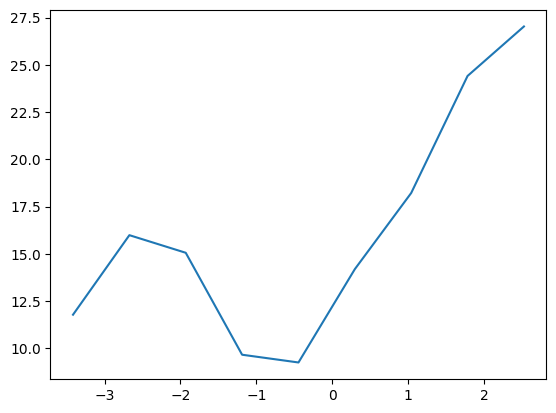

In [33]:
plt.plot(bins[:-1], distances)